---
## ODF Classifier with BioBERT 
---
### Content
---

- **[Libraries to use](#Libraries_to_use)**

- **[Loading the dataset](#Loading_dataset)**

- **[Cleaning the dataset and extracting required features](#Cleaning_extracting)**

- **[Including reversed findings to the dataset](#Reversed_findings)**

- **[Creating a dictionary with train, test, validation datasets](#train_test_validation)**

- **[Load tokenizer and model](#tokenizer_model)**

- **[Tokenize the datasets](#tokenize)**

- **[Formating to torch](#Formating)**

- **[Extracting hidden states](#Extracting_hidden_states)**

- **[Creating a feature matrix](#feature_matrix)**

- **[Visualizing the training set](#Visualizing_training)**

- **[Training a classifier](#Training_classifier)**

 ---

---
### Libraries to use <a id="Libraries_to_use"> </a>
---

In [21]:
#------------------------------------------------------
# Regular modules
#------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
#------------------------------------------------------
# To avoid warnings
#------------------------------------------------------
import os
import warnings 
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#------------------------------------------------------
# Not regular modules
#------------------------------------------------------
import datasets
import torch
from umap import UMAP
from transformers import AutoTokenizer, AutoModel
#------------------------------------------------------
# Created modules
#------------------------------------------------------
from Classifier import data_cleaning  
from Classifier import including_reversing 
from Classifier import train_test_validation  

---
### Loading the dataset <a id="Loading_dataset"> </a>
---

In [2]:
OGD_FakeSet = pd.read_csv("../data/OGD_FakeSet.csv")

In [3]:
OGD_FakeSet.head()

,text
0,"Hospital Number: O8583042 , Hospital: Random N..."
1,"Hospital Number: H2587908 , Hospital: Random N..."
2,"Hospital Number: P9907275 , Hospital: Random N..."
3,"Hospital Number: D9990587 , Hospital: Random N..."
4,"Hospital Number: K9010769 , Hospital: Random N..."


---
### Cleaning the dataset and extracting required features <a id="Cleaning_extracting"> </a>
---

In [4]:
df = data_cleaning(OGD_FakeSet)

In [5]:
df.head()

,extent_of_exam,indications,findings
0,D1,Biopsies for H pylori,The patient has Barrett's oesophagus. It is a ...
1,D1,Known coeliac ch diarrhoea.Myelofibrosis on r...,There is a polyp in the antrum which is sessil...
2,Failed intubation,Known coeliac disease vomitting,The patient has inflammation in the second par...
3,Pylorus,Reflux-like Symptoms/Atypical Chest Pain,Normal gastroscopy to the duodenum.
4,Pylorus,Dysphagia/Odynophagia post oesophagectomy,There is an ulcer in the second part of the du...


---
### Including reversed findings to the dataset <a id="Reversed_findings"> </a>
---

In [6]:
sentences = including_reversing(df)

In [7]:
sentences.tail(3)

,findings,label
1997,.tnemtaert dna noitaulave rehtruf rof tsigoloc...,0
1998,AN .munedoud eht ot ypocsortsag lamroN,0
1999,"\r ,""noollab ERC a htiw mm 5 ot detalid"" ,""noo...",0


---
### Creating a dictionary with train, test, validation datasets <a id="train_test_validation"> </a>
---

In [8]:
Dict_datasets = train_test_validation(sentences)

In [9]:
Dict_datasets

DatasetDict({
    train: Dataset({
        features: ['findings', 'label'],
        num_rows: 980
    })
    test: Dataset({
        features: ['findings', 'label'],
        num_rows: 600
    })
    validation: Dataset({
        features: ['findings', 'label'],
        num_rows: 420
    })
})

---
### Load tokenizer and model <a id="tokenizer_model"> </a>
---

- BioBERT is a pre-trained language model that is designed for biomedical natural language processing (NLP) tasks. It is based on the Google's BERT (Bidirectional Encoder Representations from Transformers) architecture.

- BioBERT is pre-trained on a large corpus of biomedical text data, which includes abstracts and full-text articles from PubMed Central and other biomedical databases. 

---

In [10]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

In [11]:
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1", num_labels=2)

---
### Tokenize the datasets <a id="tokenize"> </a>
---

In [12]:
#--------------------------------------------------------------------
# define function to tokenize the datasets
#--------------------------------------------------------------------
def tokenize(data):
    return tokenizer(data["findings"], padding=True, truncation=True,max_length=10) 
#--------------------------------------------------------------------
# tokenize datasets
#--------------------------------------------------------------------
Dict_datasets_encoded = Dict_datasets.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/980 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

---
### Formating to torch <a id="Formating"> </a>
---

In [13]:
Dict_datasets_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

---
### Extracting hidden states <a id="Extracting_hidden_states"> </a>
---

How will extract the hidden states associated with each finding.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    print('.')
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

dataset_hidden = Dict_datasets_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/980 [00:00<?, ? examples/s]

.


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

.


Map:   0%|          | 0/420 [00:00<?, ? examples/s]

.


---
### Creating a feature matrix <a id="feature_matrix"> </a>
---

We will use the hidden states as input features and the labels as targets.

In [15]:
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
X_test = np.array(dataset_hidden["test"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])
y_test = np.array(dataset_hidden["test"]["label"])
X_train.shape, X_valid.shape, X_test.shape

((980, 768), (420, 768), (600, 768))

---
### Visualizing the training set <a id="Visualizing_training"> </a>
---

In [16]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,-13.868543,18.740314,0
1,-2.738768,-18.339489,0
2,7.693869,-0.802762,1
3,-5.630796,14.579588,1
4,26.201723,18.428625,1


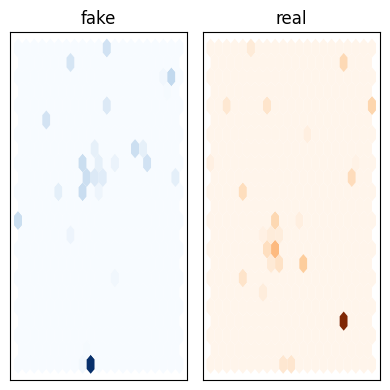

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(4,4))
axes = axes.flatten()
cmaps = ["Blues", "Oranges"]
labels = ['fake','real']

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

---
### Training a classifier <a id="Training_classifier"> </a>
---

In [18]:
lr_clf = LogisticRegression(max_iter=100)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

1.0

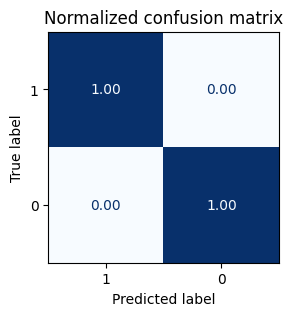

In [23]:
y_preds = lr_clf.predict(X_test)

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(3, 3))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_test, [1,0])